# EN.601.475/675 Translation from Russian to Everyday English using a Model of A recurrent Neural Network (TREEMANN) Project

Zoe Kim(mkim205), Kyllie Furukawa(kfuruka2), Stella Li(sli136), Brandon Wong(bwong19) \\



---




**Aim**: To develop a Russian-English sequence to sequence (seq2seq) neural machine translation model using Recurrent Neural Networks, and to perform hyperparameter tuning in this particular problem space. 




#Project Walkthrough

In [ ]:
#import libraries
from __future__ import unicode_literals, print_function, division

import math
import random
import datetime
import pytz
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from nltk.translate.bleu_score import corpus_bleu
from io import open

**Dataset**

The bilingual English-Russian dataset was downloaded from Kaggle: \\
https://www.kaggle.com/hijest/englishrussian-dictionary-for-machine-translate.




In [ ]:
# download dataset
!wget "https://github.com/zoekimm/475/blob/main/scripts/english-russian.txt.zip?raw=true"
!unzip /content/english-russian.txt.zip?raw=true

--2021-12-14 21:32:11--  https://github.com/zoekimm/475/blob/main/scripts/english-russian.txt.zip?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/zoekimm/475/raw/main/scripts/english-russian.txt.zip [following]
--2021-12-14 21:32:12--  https://github.com/zoekimm/475/raw/main/scripts/english-russian.txt.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zoekimm/475/main/scripts/english-russian.txt.zip [following]
--2021-12-14 21:32:12--  https://raw.githubusercontent.com/zoekimm/475/main/scripts/english-russian.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connecte

In [ ]:
#define constants for SOS and EOS 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = "<SOS>" #start of the sentence token
EOS_token = "<EOS>" #end of the sentence token

SOS_index = 0
EOS_index = 1
MAX_LENGTH = 10
reverse = False

# Data Preprocessing

**1.1.2 Must Accomplish**: Code a basic framework of the model such that it can be trained on a dataset (split into train/validate/test) and generate an output on test data, regardless of accuracy.


---

Based on the given language code, vocab class is responsible for encoding/decoding a word and an index. Word2index, word2count and index2word are stored as dictionary objects, and n_words shows how many unique words are in each dataset.


In [ ]:
class Vocab:
    def __init__(self, lang_code):
        self.lang_code = lang_code
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_index: SOS_token, EOS_index: EOS_token}
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

**1.1.1 Must Accomplish**: Develop the pre-processing code that is able to take in the raw data and clean it up so that it is ready for training and testing with the model. \\



---

The dataset is split into source_data (Russian) and target_data (English). 

In [ ]:
#source_data(Russian) and target_data(English)
with open('./english-russian.txt', encoding='utf8') as f:
    en_data = [line.split('\t')[0] for line in f]
with open('./english-russian.txt', encoding='utf8') as f:
    ru_data = [line.split('\t')[1] for line in f]

In order to choose a MAX_LENGTH value that both ensures reasonable program runtime and covers the majority of sentences, we decided to include sentences that are at most 10 words, which covers 96.6% of the original corpus. 

In [ ]:
from collections import defaultdict
count = defaultdict(int)

buckets = [0, 1, 2, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
for sent in en_data:
    n = len(sent.split())
    for bucket in buckets[::-1]:
      if n >= bucket:
        count[bucket] += 1
        break

count

defaultdict(int,
            {1: 103,
             2: 6087,
             3: 87689,
             5: 245688,
             10: 22108,
             15: 1505,
             20: 162,
             25: 27,
             30: 13,
             40: 3,
             100: 1})

In [ ]:
print(MAX_LENGTH)
en_temp = []
ru_temp = []
for en, ru in zip(en_data, ru_data):
    if len(en.split()) < MAX_LENGTH and len(en.split()) > 5 and len(ru.split()) < MAX_LENGTH and len(ru.split()) > 5:
        en_temp.append(en)
        ru_temp.append(ru)
en_data = en_temp
ru_data = ru_temp

10


With this dataset of English and Russian parallel corpus, we decided to do Russian $\rightarrow$ English translation, because the generated English translation can be compared to the target English sentences to help make the BLEU scores more intuitive.

BLEU stands for Bilingual Evaluation Understudy Score, and is a score ranging from 0 to 1 to indicate how well a generated sentence matches a reference sentence, in order to evaluate machine translations. It compares the number of n-grams in the reference, to n-grams in the translation. A '1' indicates a perfect match, and a '0' indicates no matching n-grams. 

In [ ]:
src_lang_code = 'ru'
tgt_lang_code = 'en'

source_data = ru_data
target_data = en_data

**1.2.3 Expect to accomplish**: One more optimization based on what we learned in class, a plausible implementation would be Teacher Forcing during Training, where the target is fed into the next cell in the RNN instead of the prediction.

---

According to "Sequence to Sequence Learning with Neural Networks", Sutskever et al. (2014) have shown that reversing the input in Long short-term memory would improve the perfomance of the model. Therefore, along with Teacher Forcing during Training, reversing the source input was also implemented in our project for optimization purposes.

Ilya Sutskever, Oriol Vinyals, and Quoc V. Le. 2014. Sequence to sequence learning with neural networks. In <i>Proceedings of the 27th International Conference on Neural Information Processing Systems - Volume 2</i> (<i>NIPS'14</i>). MIT Press, Cambridge, MA, USA, 3104–3112.



In [ ]:
if reverse:
    for i, source in enumerate(source_data):
        source = source.split(' ')
        source.reverse
        source = ' '.join(source)
        source_data[i] = source



---
Scikit-learn package was used to split the data into into train, validation, and test sets with test_size = 0.5. A pair of source and target was created for each train, validation, and test set so that each could be put into the corresponding tensor during training.


In [ ]:
#train, validation, and test sets using Scikit-learn package
from sklearn.model_selection import train_test_split
total_test = len(source_data)//100
src_train, src_subtotal, tgt_train, tgt_subtotal = train_test_split(
        source_data, target_data, test_size=total_test, random_state=42)

src_test, src_val, tgt_test, tgt_val = train_test_split(
        src_subtotal, tgt_subtotal, test_size=0.5, random_state=42)

In [ ]:
# generate vocab for source and target sentences
src_vocab = Vocab(src_lang_code)
tgt_vocab = Vocab(tgt_lang_code)

for source, target in zip(src_train, tgt_train):
    src_vocab.add_sentence(source)
    tgt_vocab.add_sentence(target)

In [ ]:
#create a pair of (source, target) for each set
train_pairs = [[src_train[i], tgt_train[i]] for i in range(len(src_train))]
dev_pairs = [[src_val[i], tgt_val[i]] for i in range(len(src_val))]
test_pairs = [[src_test[i], tgt_test[i]] for i in range(len(src_test))]

## Exploratory Data Analysis


---

Below is some more exploratory data analysis after pre-processing the data. Here, we are comparing frequencies of words in the source vocab and the target vocab.

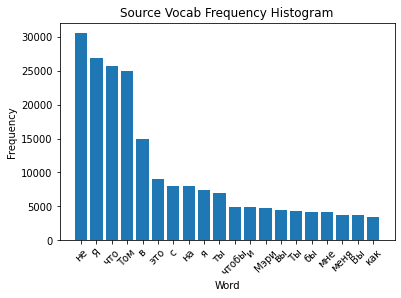

In [ ]:
src_count = src_vocab.word2count
src_count_top = dict(sorted(src_count.items(), key=lambda x: x[1], reverse=True)[:20])

plt.bar(src_count_top.keys(), src_count_top.values())
plt.xticks(rotation=45)
plt.title('Source Vocab Frequency Histogram')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

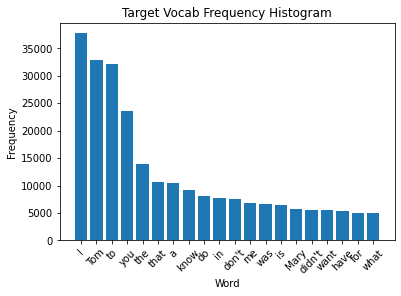

In [ ]:
tgt_count = tgt_vocab.word2count
tgt_count_top = dict(sorted(tgt_count.items(), key=lambda x: x[1], reverse=True)[:20])

plt.bar(tgt_count_top.keys(), tgt_count_top.values())
plt.xticks(rotation=45)
plt.title('Target Vocab Frequency Histogram')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

Given the frequencies of the 20 most common words, we compare the source and target vocab. Upon basic searching, some of these words do not match their translation.

In [ ]:
top_pairs = list(zip(src_count_top.keys(), tgt_count_top.keys()))
print(top_pairs)

[('не', 'I'), ('Я', 'Tom'), ('что', 'to'), ('Том', 'you'), ('в', 'the'), ('это', 'that'), ('с', 'a'), ('на', 'know'), ('я', 'do'), ('ты', 'in'), ('чтобы', "don't"), ('и', 'me'), ('Мэри', 'was'), ('вы', 'is'), ('Ты', 'Mary'), ('бы', "didn't"), ('мне', 'want'), ('меня', 'have'), ('Вы', 'for'), ('как', 'what')]


# Encoder Decoder Model Architecture

---

The encoder-decoder architecture and training/testing functions were implemented based on [Bahdanau et al. 2015](https://arxiv.org/pdf/1409.0473.pdf) "NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE" and the [offical pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) "NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION".

In [ ]:
#define constants for the encoder/decoder model and for the optimizer
hidden_size = 256
initial_learning_rate = 0.001

EncoderRNN class is responsible for reading in the input sequence and outputting the context vector for the decoder class to take in. While the paper and the official tutorial both used Gated Recurrent Unit for RNN, LSTM cell was used for RNN in this project. In forward function, EncoderRNN outputs a context vector and hidden states.

In [ ]:
class EncoderRNN(nn.Module):
    """the class for the enoder RNN
    """
    def __init__(self, input_size, hidden_size, code=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.M = 620
        self.embedding = nn.Embedding(input_size, hidden_size, device=device)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(BATCH_SIZE, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def get_initial_hidden_state(self):
        return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)

**1.3.1 Would like to accomplish**: Implement and experiment with different types of attentions (Luong et al., 2015).



---
From the paper, attention can help with both aligning and translating in machine translation. Therefore, AttnDecoderRNN class uses attention mechanism that can filter a certain input sequence, especially given a complex, long sentence is given as an input. Equations used in this model were adopted from the paper. 


In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, alignment="global", score="concat", dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.alignment = alignment
        self.score = score
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.M = 620

        self.dropout = nn.Dropout(self.dropout_p)
        self.embedding = nn.Embedding(output_size, self.M, device=device)
  
        self.W_s = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size).to(device))
        torch.nn.init.normal_(self.W_s, mean = 0.0, std = 0.01)
        self.biasW_s = nn.Parameter(torch.zeros(self.hidden_size, 1, device=device))

        #self.context = AlignmentRNN(self.hidden_size, self.max_length)
        self.context = AlignmentRNN(self.hidden_size, self.alignment, self.score, self.max_length)
        self.maxout = MaxoutLayer(self.output_size, self.hidden_size, self.M)
        self.lstm = nn.LSTM(self.M + 2 * hidden_size, hidden_size, batch_first = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim = 0)

    def forward(self, input, hidden, encoder_outputs, di):
        E_yi = self.embedding(input).view(BATCH_SIZE, 1, self.embedding.embedding_dim)
        E_yi = self.dropout(E_yi)
        sprior = hidden[0].view(BATCH_SIZE, -1)
        sprior = torch.transpose(sprior, 0, 1)

        #e = a(sprior, h) -> attn_weights -> ci
        ci, attn_weights = self.context(sprior, encoder_outputs, di)
        
        c_v = ci.view(BATCH_SIZE, 1, -1)
        combine = torch.cat((E_yi, c_v), 2)
        #s_i = f(sprior, yprior, ci)
        output, hidden = self.lstm(combine, hidden)

        E_yi = torch.transpose(E_yi.view(BATCH_SIZE, self.embedding.embedding_dim), 0, 1)
        #log_softmax(ti) ~ p(y_i | s_(i-1), y_(i-1), c_i)
        ti = self.maxout(sprior, E_yi, ci)
        
        log_softmax = torch.log_softmax(ti, 0)
        log_softmax = torch.transpose(log_softmax, 0, 1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return log_softmax, hidden, attn_weights

    def get_initial_hidden_state(self, hidden):
        return torch.tanh(self.W_s @ hidden + self.biasW_s)

We looked at five different types of attention, with the two broad categories being global and local attention. Global attention refers to the model considering the entire context of a sentence in order to translate a word, by computing a context vector that is based on all of the hidden states. Local attention, on the other hand, is the model that derives a context vector by using a "window" of hidden states centered around the current word position. 

The specific attentions are summarized below: 

*   global location: utilizes a location-based alignment function (figure 1) to compute the context vector as a weighted average over all of the hidden states
*   global general: uses the general scoring function (figure 3, labeled 'general'), and the alignment function (figure 2) that compares the current hidden target to each of the hidden targets 
*   global concat: performs layer concatenation with the concat scoring function (figure 3, labeled 'concat'), and the alignment function (figure 2)
*   monotonic alignment (local-m) concat: assumes that the target and source are roughly aligned, so p_t = t. The alignment function (figure 5) uses the Gaussian distribution to favor points around p_t
*   predictive alignment (local-p) concat: predicts an alignment position (figure 4). Again, the alignment function used is in figure 5


**Figure 1**:          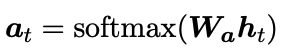

**Figure 2**: 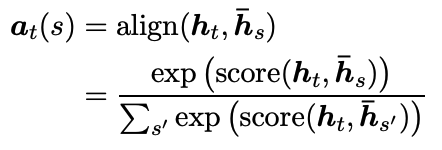

**Figure 3**: 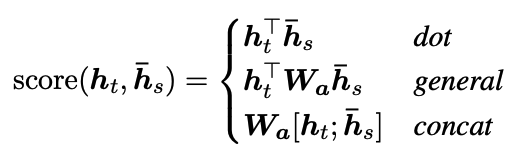


**Figure 4**: 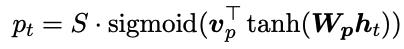

**Figure 5**: 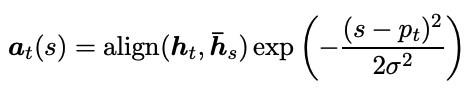

The implementation of the different attention parameters are mainly defined in the following AlignmentRNN class:

In [ ]:
class AlignmentRNN(nn.Module):
    def __init__(self, hidden_size, alignment="global", score="concat", max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.alignment = alignment
        self.D = 2
        self.score = score
        self.max_length = max_length

        if self.score == "general":
          self.s_a = nn.Parameter(torch.zeros(1, BATCH_SIZE, device=device))
          self.U_a = nn.Parameter(torch.Tensor(self.hidden_size, 2*self.hidden_size, device=device))
          torch.nn.init.normal_(self.U_a,mean=0.0,std=0.001)
          self.biasU_a = nn.Parameter(torch.zeros(self.hidden_size, 1, device=device))
        if self.score == "location":
          self.B_a = nn.Parameter(torch.Tensor(self.max_length, self.hidden_size, device=device))
          # self.B_a = nn.Parameter(torch.Tensor(self.max_length, self.hidden_size).to(device))
          torch.nn.init.normal_(self.B_a,mean=0.0,std=0.001)
        if self.score == "concat":
          self.W_a = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size, device=device))
          torch.nn.init.normal_(self.W_a,mean=0.0,std=0.001)
          self.U_a = nn.Parameter(torch.Tensor(self.hidden_size, 2*self.hidden_size, device=device))
          torch.nn.init.normal_(self.U_a,mean=0.0,std=0.001)
          self.biasU_a = nn.Parameter(torch.zeros(self.hidden_size, 1, device=device))
          self.biasW_a = nn.Parameter(torch.zeros(self.hidden_size, 1, device=device))
          self.v_a = nn.Parameter(torch.zeros(1, self.hidden_size, device=device))

        # learn predictive alignment position params
        if self.alignment == "local-p":
          self.W_p = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size, device=device))
          torch.nn.init.normal_(self.W_a,mean=0.0,std=0.001)
          self.v_p = nn.Parameter(torch.zeros(1, self.hidden_size, device=device))
          self.u_p = nn.Parameter(torch.zeros(BATCH_SIZE, 1, device=device))  
        
    def forward(self, sprior, encoder_outputs, t):
        attn_weights = torch.zeros(self.max_length, BATCH_SIZE, device=device)
        p_t = t
        if self.alignment == "local-p":
            p_t = self.max_length * torch.sigmoid(self.v_p @ torch.tanh(self.W_p @ sprior) @ self.u_p)
        start = 0
        end = self.max_length
        if self.alignment != "global":
            start = int(max(p_t - self.D, 0))
            end = int(min(p_t + self.D, self.max_length))
        if self.score == "general":
            #attn_weight[j] = currentTargetHidden.transpose @ W_a \in R^{hiddenSize*hiddenSize} @ sourceHiddens[j]
            for j in range(start, end):
                '''try to precompute U_a hj outside this decoder (as no dependance on i and is same every forward pass)'''
                encoder_output = torch.cat((encoder_outputs[j, :, 0], encoder_outputs[j, :, 1]), 1)
                encoder_output = torch.transpose(encoder_output, 0, 1)
                attn_weights[j] = self.s_a @ torch.tanh(torch.transpose(sprior,0,1) @ (self.U_a @ encoder_output + self.biasU_a))
                if self.alignment != "global":
                    attn_weights[j] *= math.exp(-(j - p_t)**2/2*(self.D/2)**2)
        elif self.score == "concat":
            #e_ij = a(s_(i-1), h_j) = v_a.transpose * tanh(W_a * s_(i-1) + U_a * h_j)
            for j in range(start, end):
                encoder_output = torch.cat((encoder_outputs[j, :, 0], encoder_outputs[j, :, 1]), 1)
                encoder_output = torch.transpose(encoder_output, 0, 1)
                attn_weights[j] = self.v_a @ torch.tanh(self.W_a @ sprior + self.biasW_a \
                                                        + self.U_a @ encoder_output + self.biasU_a)
                if self.alignment != "global":
                    attn_weights[j] *= math.exp(-(j - p_t)**2/2*(self.D/2)**2)
        elif self.score == "location":
            attn_weights = self.B_a @ sprior

        #a_ij = exp(e_ij) / sum_{k=1}^{T_x} exp(e_ik)
        attn_weights = torch.softmax(attn_weights, dim=0)
        ci = torch.zeros(2*self.hidden_size, BATCH_SIZE, device=device)
        #c_i = q(s_(i-1), h) = sum_{j=1}^{T_x} _ij h_j ; hj [ forwardHj ; backwardHj] \in R^2n
        # filter = np.random.choice(attn_weights)
        for j in range(self.max_length):
            ci[:self.hidden_size] += attn_weights[j] * torch.transpose(encoder_outputs[j, :, 0], 0, 1)
            ci[self.hidden_size:] += attn_weights[j] * torch.transpose(encoder_outputs[j, :, 1], 0, 1)
        '''
        #e_ij = a(s_(i-1), h_j) = v_a.transpose * tanh(W_a * s_(i-1) + U_a * h_j)
        for j in range(self.max_length):
            #try to precompute U_a hj outside this decoder (as no dependance on i and is same every forward pass)
            encoder_output = torch.cat((encoder_outputs[j, :, 0], encoder_outputs[j, :, 1]), 1)
            encoder_output = torch.transpose(encoder_output, 0, 1)
            attn_weights[j] = self.v_a @ torch.tanh(self.W_a @ sprior + self.biasW_a \
                                                    + self.U_a @ encoder_output + self.biasU_a)
        #a_ij = exp(e_ij) / sum_{k=1}^{T_x} exp(e_ik)
        attn_weights = torch.softmax(attn_weights, dim=0)
        ci = torch.zeros(2*self.hidden_size, BATCH_SIZE, device=device)
        #c_i = q(s_(i-1), h) = sum_{j=1}^{T_x} _ij h_j ; hj [ forwardHj ; backwardHj] \in R^2n
        for j in range(self.max_length):
            ci[:self.hidden_size] += attn_weights[j] * torch.transpose(encoder_outputs[j, :, 0], 0, 1)
            ci[self.hidden_size:] += attn_weights[j] * torch.transpose(encoder_outputs[j, :, 1], 0, 1)

        '''
        return ci, attn_weights

class MaxoutLayer(nn.Module):
    def __init__(self, output_size, hidden_size, M):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.M = M

        #Wo \in R^{Ky x l}, Uo \in R^{2l x n}, Vo \in R^{2l x m}, Co \in R^{2l x 2n}
        self.W_o = nn.Parameter(torch.Tensor(self.output_size, self.hidden_size//2).to(device))
        torch.nn.init.normal_(self.W_o,mean=0.0,std=0.01)
        self.U_o = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size).to(device))
        torch.nn.init.normal_(self.U_o,mean=0.0,std=0.01)
        self.V_o = nn.Parameter(torch.Tensor(self.hidden_size, self.M).to(device))
        torch.nn.init.normal_(self.V_o,mean=0.0,std=0.01)
        self.C_o = nn.Parameter(torch.Tensor(self.hidden_size, 2*self.hidden_size).to(device))
        torch.nn.init.normal_(self.C_o,mean=0.0,std=0.01)

        self.biasW_o = nn.Parameter(torch.zeros(self.output_size, 1, device=device))
        self.biasU_o = nn.Parameter(torch.zeros(self.hidden_size, 1, device=device))
        self.biasV_o = nn.Parameter(torch.zeros(self.hidden_size, 1, device=device))
        self.biasC_o = nn.Parameter(torch.zeros(self.hidden_size, 1, device=device))
        
    def forward(self, sprior, E_yi, ci):
        #~t_i = U_o * s_(i-1) + V_o E y_(i-1) + C_o * c_i
        ti_ = self.U_o @ sprior + self.biasU_o + self.V_o @ E_yi + self.biasV_o + self.C_o @ ci + self.biasC_o
        #t_i = [max{~t_i,2j-1, ~t_i,2j}].transpose; for j = 1, … , l
        ti = torch.zeros(self.hidden_size//2, BATCH_SIZE, device=device)
        for j in range(self.hidden_size//2):
            for b in range(BATCH_SIZE):
                ti[j, b] = max(ti_[2*j - 1, b], ti_[2*j, b])
        #W_o * t_i \in R^Ky (linearly map to vocabulary size)
        ti = self.W_o @ ti + self.biasW_o
        return ti

**1.2.2 Expect to accomplish**: Bidirectional LSTM - to optimize the accuracy of our model (Sundermeyer et al., 2014).

---
With EncoderRNN class holding LSTM memory cells, this EncoderRNN class was called for both encoder and encoderback to create a bidirectional LSTM input for the decoder as follows. 



In [ ]:
encoder = EncoderRNN(src_vocab.n_words, hidden_size).to(device)
encoderBack = EncoderRNN(src_vocab.n_words, hidden_size).to(device)
# decoder = AttnDecoderRNN(hidden_size, tgt_vocab.n_words, alignment="global", \
#                         score="location", dropout_p=0.1).to(device)

# decoder = AttnDecoderRNN(hidden_size, tgt_vocab.n_words, alignment="global", \
#                         score="general", dropout_p=0.1).to(device)

decoder = AttnDecoderRNN(hidden_size, tgt_vocab.n_words, alignment="global", \
                         score="concat", dropout_p=0.1).to(device)

# decoder = AttnDecoderRNN(hidden_size, tgt_vocab.n_words, alignment="local-p", \
#                         score="concat", dropout_p=0.1).to(device)

# decoder = AttnDecoderRNN(hidden_size, tgt_vocab.n_words, alignment="local-m", \
#                         score="concat", dropout_p=0.1).to(device)


It is in the above code (where we define the decoder) where we adjusted the parameters to run experiments for different attention models. 

The different variations that were run are commented out. 

An optimizer that implements the Adam algorithm and the negative log likelihood loss were used for the model. 

In [ ]:
# set up optimization(Adam)/loss(NLLLoss)
params = list(encoder.parameters()) + list(encoderBack.parameters())+ list(decoder.parameters())  # .parameters() returns generator
optimizer = optim.Adam(params, lr=initial_learning_rate)
criterion = nn.NLLLoss()

# Training


---

Both train and translate functions were written based on the [offical pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) "NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION".. Helper functions (tensor_from_sentence and tensors_from_pair) were used to create an input tensor and a target tensor for training.


In [ ]:
def tensor_from_sentence(vocab, sentence):
    indexes = []
    for word in sentence.split():
        try:
            indexes.append(vocab.word2index[word]) # get index of the word 
        except KeyError: # account for words missing due to attention 
            pass
    indexes.append(EOS_index)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_pair(src_vocab, tgt_vocab, pair):
    input_tensor = tensor_from_sentence(src_vocab, pair[0])
    target_tensor = tensor_from_sentence(tgt_vocab, pair[1])
    return input_tensor, target_tensor


**1.2.3 Expect to accomplish**: One more optimization based on what we learned in class, a plausible implementation would be Teacher Forcing during Training, where the target is fed into the next cell in the RNN instead of the prediction.

---
Teacher Forcing is a strategy that feeds the target word as an input, and this was used to make the model converge faster. teacher_forcing_ratio was set to 0.5, and this strategy was randomly chosen during training (use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False). 

In [ ]:
format = "%Y-%m-%d %H:%M:%S" 
timezone = pytz.timezone("America/New_York") #to see the elpased time 

print_loss_total = 0
teacher_forcing_ratio = 0.5

In [ ]:
def train(input_tensor, target_tensor, encoder, encoderBack, decoder, optimizer, criterion, teacher_forcing_ratio, max_length = MAX_LENGTH):

    encoder_hidden = (encoder.get_initial_hidden_state(), encoder.get_initial_hidden_state())

    encoder.train()
    encoderBack.train()
    decoder.train()

    loss = 0
    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, BATCH_SIZE, 2, encoder.hidden_size, device=device)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei, :, 0, :] += encoder_output[:, 0, :]
    
    encoder_hidden = (encoderBack.get_initial_hidden_state(), encoderBack.get_initial_hidden_state())

    for ei in range(input_length-1, -1, -1):
        encoder_output, encoder_hidden = encoderBack(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei, :, 1, :] += encoder_output[:, 0, :]

    decoder_input = torch.empty(BATCH_SIZE, 1, dtype=torch.long, device=device).fill_(SOS_index)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    #use_teacher_forcing = False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, di)
            loss += criterion(decoder_output, target_tensor[di].view(-1))
            decoder_input = target_tensor[di].view(-1)
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, di) 
            topv, topi = decoder_output.data.topk(1)
            loss += criterion(decoder_output, target_tensor[di].view(-1))
            decoder_input = topi.view(BATCH_SIZE, 1).detach() 

            if torch.all(decoder_input == EOS_index): #end of the sentence
                break

    loss.backward()
    optimizer.step()
    
    return loss.item()

Translate function is like an "evaluation" process where the predicted output from the decoder (an index) is converted into a word. This conversion is repeated until EOS token is reached (topi[b].item() == EOS_index).

Here, translate_random_sentence function was used for subjective quality judgements during training so to see both the input and output sentences.


In [ ]:
def translate(encoder, encoderBack, decoder, sentences, src_vocab, tgt_vocab, max_length=MAX_LENGTH):

    encoder.eval()
    encoderBack.eval()
    decoder.eval()

    with torch.no_grad():
        input_tensor = torch.empty(MAX_LENGTH, BATCH_SIZE, 1, dtype=torch.long, device=device).fill_(EOS_index)
        for (i, sentence) in enumerate(sentences):
            tfs = tensor_from_sentence(src_vocab, sentence)
            input_tensor[:tfs.size(0), i, :] = tfs
        input_length = input_tensor.size(0)
        encoder_hidden = (encoder.get_initial_hidden_state(), encoder.get_initial_hidden_state())

        encoder_outputs = torch.zeros(max_length, BATCH_SIZE, 2, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei, :, 0, :] += encoder_output[:, 0, :]
        
        encoder_hidden = (encoderBack.get_initial_hidden_state(), encoderBack.get_initial_hidden_state())

        for ei in range(input_length-1, -1, -1):
            encoder_output, encoder_hidden = encoderBack(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei, :, 1, :] += encoder_output[:, 0, :]

        decoder_input = torch.empty(BATCH_SIZE, 1, dtype=torch.long, device=device).fill_(SOS_index)
        decoder_hidden = encoder_hidden
        decoded_words = [[] for i in range(len(sentences))] 
        decoder_attentions = torch.zeros(max_length, max_length, BATCH_SIZE)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, di)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            for b in range(len(sentences)):
                if len(decoded_words) > b and EOS_token in decoded_words[b]:
                    continue
                if topi[b].item() == EOS_index:
                    decoded_words[b].append(EOS_token)
                else:
                    decoded_words[b].append(tgt_vocab.index2word[topi[b].item()])

            decoder_input = topi.view(BATCH_SIZE, 1).detach()
        
        output_sentences = [' '.join(sentence) for sentence in decoded_words]
        return output_sentences, decoder_attentions


# Translate (dev/test)set takes in a list of sentences and writes out their transaltes
def translate_sentences(encoder, encoderBack, decoder, pairs, src_vocab, tgt_vocab, max_num_sentences=None, max_length=MAX_LENGTH):
    output_sentences = []
    count = 0
    while count < len(pairs):
        sentences = []
        for i in range(BATCH_SIZE):
            sentences.append(pairs[count][0])
            count += 1
            if count >= len(pairs):
                break
        output_words, attentions = translate(encoder, encoderBack, decoder, sentences, src_vocab, tgt_vocab)
        # output_sentence = ' '.join(output_words)
        output_sentences = output_sentences + output_words
    return output_sentences


def translate_random_sentence(encoder, encoderBack, decoder, pairs, src_vocab, tgt_vocab, n=1):
    sentences = []
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        sentences.append(pair[0])
        if (n > BATCH_SIZE):
            sentences = [pair[0]]
            output_words, attentions = translate(encoder, encoderBack, decoder, sentences, src_vocab, tgt_vocab)
    if (n <= BATCH_SIZE):
        output_words, attentions = translate(encoder, encoderBack, decoder, sentences, src_vocab, tgt_vocab)
    for sentence in output_words:
        print('<', sentence)
        print('')

def clean(strx):
    """remove bpe and EOS
    """
    return ' '.join(strx.replace('@@ ', '').replace(EOS_token, '').strip().split())    

**1.2.1 Expect to accomplish**: Batch size hyperparameter searching - finding the optimal batch size that would both optimize the BLEU scores of our model and train in a reasonable time.

---
A batch size of (1, 4, 8, 16, 32, 64, 128) was tested to determine the batch size that would give both optimal BLEU score and training time. A batch size of 16 was the optimal batch size from the hyperparameter searching described below.


In [ ]:
#define more constants for training
BATCH_SIZE = 16
n_iters = 256000
print_update_every = 256
print_bleu_every = 2560

**1.1.3 Must accomplish**: Utilize at least one machine learning technique learned in class to optimize runtime of the model (the most promising optimization that we will implement is batching)

---

To optimize the runtime of the model, the input and target tensor were filled with EOS token and a pair from the training set was chosen for a given batch size. Then, a random sentence from a validation (dev) set was chosen to calculate the Dev BLEU score. 

Note: running this cell with 256000 iterations will result in a runtime on the magnitude of hours.

In [ ]:
iter_num = 0
print_loss_total = 0
bleus = []
times = []

start = datetime.datetime.now(timezone) #to see the progress and elpased time

while iter_num < n_iters:
    if iter_num % print_update_every == 0:
        now = datetime.datetime.now(timezone)
        times.append(now)
        print(now.strftime(format) + " " + str(iter_num) + ": " + str(print_loss_total) + " t=" + str((now-start).total_seconds()))

    input_tensor = torch.empty(MAX_LENGTH, BATCH_SIZE, 1, dtype=torch.long, device=device).fill_(EOS_index)
    target_tensor = torch.empty(MAX_LENGTH, BATCH_SIZE, 1, dtype=torch.long, device=device).fill_(EOS_index)

    for i in range(BATCH_SIZE):
        #random pair from the training set 
        training_pair = tensors_from_pair(src_vocab, tgt_vocab, random.choice(train_pairs))
        input_tensor[:training_pair[0].size(0), i, :] = training_pair[0]
        target_tensor[:training_pair[1].size(0), i, :] = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, encoderBack, decoder, optimizer, criterion, teacher_forcing_ratio)
    print_loss_total += loss


    if iter_num % print_bleu_every == 0:
        print_loss_avg = print_loss_total / print_bleu_every
        print_loss_total = 0

        #random pair from the validation/dev set
        translate_random_sentence(encoder, encoderBack, decoder, dev_pairs, src_vocab, tgt_vocab, n=2)

        #print out the translated sentence for qualification
        translated_sentences = translate_sentences(encoder, encoderBack, decoder, dev_pairs, src_vocab, tgt_vocab)

        references = [[clean(pair[1]).split(), ] for pair in dev_pairs[:len(translated_sentences)]]
        candidates = [clean(sent).split() for sent in translated_sentences]
        dev_bleu = corpus_bleu(references, candidates)
        bleus.append(dev_bleu)

        print('Dev BLEU score: {}'.format(dev_bleu))

    iter_num += BATCH_SIZE

now = datetime.datetime.now(timezone)
times.append(now)
print(now.strftime(format) + " " + str(iter_num) + ": " + str(print_loss_total) + " t=" + str((now-start).total_seconds()))

translated_sentences = translate_sentences(encoder, encoderBack, decoder, dev_pairs, src_vocab, tgt_vocab)
references = [[clean(pair[1]).split(), ] for pair in dev_pairs[:len(translated_sentences)]]
candidates = [clean(sent).split() for sent in translated_sentences]

dev_bleu = corpus_bleu(references, candidates)
bleus.append(dev_bleu)

print('Dev BLEU score: {}'.format(dev_bleu))

print(bleus)
print(times)

#total running time and Dev BLEU across iterations are printed

2021-12-14 16:32:21 0: 0 t=0.000397
> Том очень хорошо умеет играть на пианино.
= Tom can play piano very well.
> А что я, по-вашему, пытаюсь сделать?
= What do you think I'm trying to do?
< Tom beverages <EOS>

< Tom beverages <EOS>



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dev BLEU score: 0.17906610802992576
2021-12-14 16:33:06 256: 829.927565574646 t=45.517104
2021-12-14 16:33:35 512: 1445.4889879226685 t=73.888806


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-078f64093f51>", line 23, in <module>
    loss = train(input_tensor, target_tensor, encoder, encoderBack, decoder, optimizer, criterion, teacher_forcing_ratio)
  File "<ipython-input-24-37f52e1b0225>", line 48, in train
    loss.backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/_tensor.py", line 307, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 156, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interacti

KeyboardInterrupt: ignored

Note: We never ran a full experiment on this "master" notebook, and instead ran all of our experiments on copies of this notebook, linked at the bottom. The output above (where we force-quitted the process after a few outputs) was just to demonstrate how the output would look given chosen parameters. 

# Generate Translation

---

After the model was created for a given batch size, the sentences in the test set were translated and were written into a corresponding file. Test BLEU score was also calculated.


In [ ]:
out_file = '/content/out_batch{}.txt'.format(BATCH_SIZE)

In [ ]:
# translate the test set and write it into out_file
translated_sentences = translate_sentences(encoder, encoderBack, decoder, test_pairs, src_vocab, tgt_vocab)
with open(out_file, 'wt', encoding='utf-8') as outf:
    for sent in translated_sentences:
        outf.write(clean(sent) + '\n')

In [ ]:
references = [[clean(pair[1]).split(), ] for pair in test_pairs[:len(translated_sentences)]]
candidates = [clean(sent).split() for sent in translated_sentences]
test_bleu = corpus_bleu(references, candidates)
print(len(translated_sentences))
print(test_bleu) #test bleu score

# Experiment Results

Now that our machine translation system is working, we start running the benchmark testing experiments.

The full raw results of all of the experiments are linked [here](https://docs.google.com/spreadsheets/d/1E7414yv1Lf6RcpUW8CYv5dtWSIRbWDxr5p-IG7BwtmQ/edit?usp=sharing), but the summaries and analyses are below.


---
**Overall:**

1. Our corpus has an excessive amount of “Tom” and “Mary.” It might be due to the fact that this is an artificially generated dataset (look into Kaggle source description). This potentially causes bias in the translation of proper nouns and would cause generalization issues for text outside of the corpus. 
2. Another potential way to compare the different hyperparamter setups would be plotting BLEU over the runtime of the program and not over iterations. This would allow us to determine how good the model can get within a set period of training. However, this won’t work for low-resource language translations where the corpus size rather than the time is the limiting factor.
3. GPU makes training a lot slower.


## Batch Size 

---

After testing a batch size of (1, 4, 8, 16, 32, 64, 128), 16 was the optimal batch size that gave both optimal BLEU score of 0.410 and training time of 2572 minutes for the first 23040 iterations for this model. Although a batch size of 8 gave a slightly higher BLEU score of 0.415, the running time was 4827 minutes. Also, it is important to point out that a batch size of 16 converged faster shown on the grpah below.

* For batching size 1, we stopped running once it reaches 50000 seconds because it already exceeded the runtime for other batch sizes for the entire training process without giving a reasonably good BLEU score.
* Teacher Forcing was applied during training.

In [ ]:
import pandas as pd
batch_size = [1, 4, 8, 16, 32, 64, 128]
run_time = [20951.136, 6561, 4827.211817, 2572.032294, 2246.234373, 2001.433826, 2245.737961]
scores = [0.2201277663,0.2721084543,0.4157099718, 0.410100712, 0.4105213116, 0.4041883547, 0.3433973328]
df = pd.DataFrame({'batch_size': batch_size, 'run time': run_time, 'scores': scores})

ax = df.plot(kind="bar", x='batch_size', y='run time')
ax.set_title("Runtime of the First 23040 Iterations")
ax.set_xlabel("Batch Size")
ax.set_ylabel("Runtime")

#ax = df.plot(kind="bar", x='batch_size', y='scores')
#ax.set_xlabel("Batch Size")
#ax.set_ylabel("BLEU score")

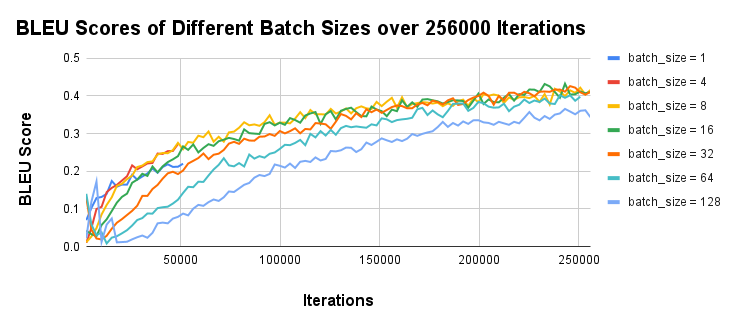

##Reverse Input and Teacher Forcing

---
Since feeding both the input and the target into the encoder in the right order would make each word equidistant from its corresponding word, the minimal distance between pairs would be large especially for a translation problem during concatenation. Therefore,  reversing the input would make the beginning of the sentences closer to each other and would allow easier communication between the input and the target through backpropagation, improving the overall performance of the machine translation model. However, reverse source sentences did not seem to an effect on the BLEU scores probably since the length of sentences were too short (MAX_LENGTH = 10) and the distance thing did not really help; BLEU score without reversing the source sentence was higher. 
Compared to the result above where the teacher forcing was applied, it can be inferred that teacher forcing helps a lot with accuracy but with slightly slower runtime, particularly for a batch size of 16.






In [ ]:
import pandas as pd
batch_size = ['8 w/ Reverse', '8 w/o Reverse', '16 w/ Reverse', '16 w/o Reverse']
run_time = [3894.460801, 3844.053693, 2626.173132, 2604.028326]
scores = [0.3239692617, 0.3435984524, 0.3178500952, 0.3276587797]
df = pd.DataFrame({'batch_size': batch_size, 'run time': run_time, 'scores': scores})

ax = df.plot(kind="bar", x='batch_size', y='run time')
ax.set_xlabel("Batch Size")
ax.set_ylabel("Runtime")

#ax = df.plot(kind="bar", x='batch_size', y='scores')
#ax.set_xlabel("Batch Size")
#ax.set_ylabel("BLEU score")

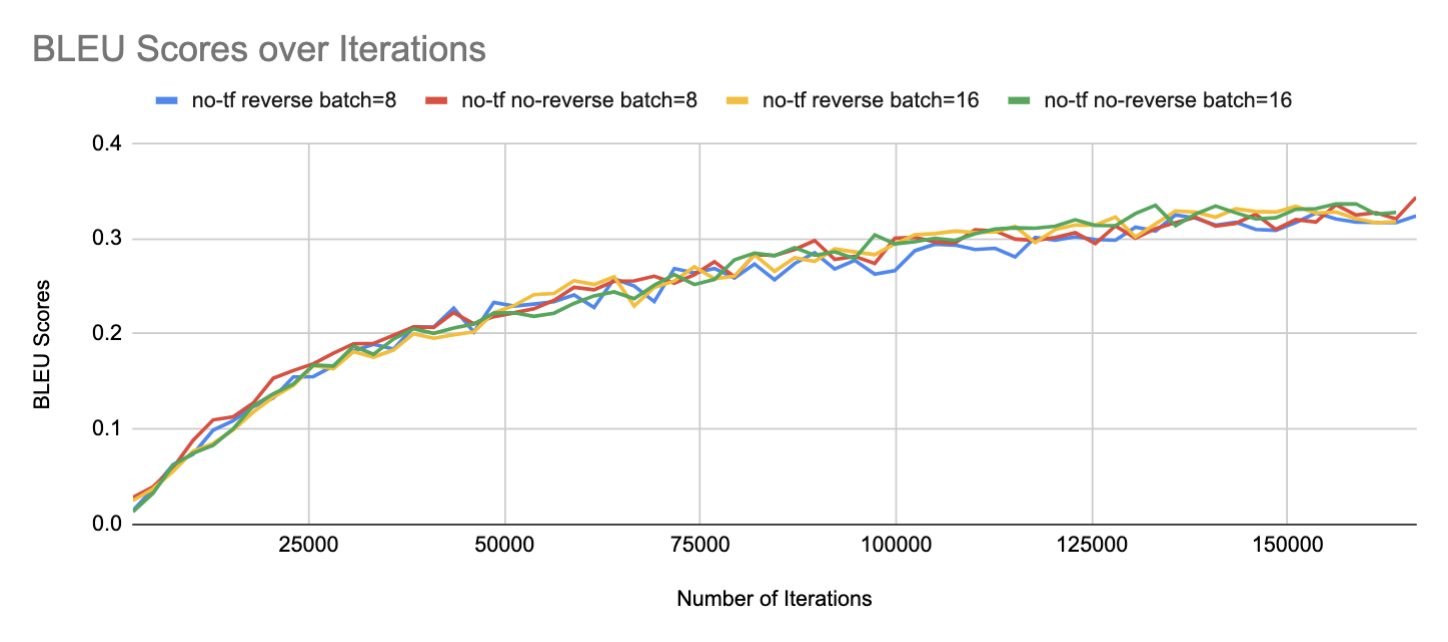

## Attention Types


---
We changed the parameters as explained in an earlier section, in order to obtain different attention models. The runtimes of each attention type are graphed below, with the BLEU scores of each model is depicted in a comparison underneath. 


In [ ]:
import pandas as pd
attention = ['Local-P Concat', 'Local-M Concat', 'Global Concat', \
             'Global Location', 'Global General']
run_time = [2358.075304, 2876.482702, 2876.070097, 2223.105793, 3014.174572]
scores = [0.364967679986629, 0.39171347587159666, 0.413031735715621, \
          0.405317565074815, 0.3835585753]
df = pd.DataFrame({'attention': attention, 'run time': run_time, 'scores': scores})

ax = df.plot(kind="bar", x='attention', y='run time')
ax.set_xlabel("Attention Type")
ax.set_ylabel("Runtime")


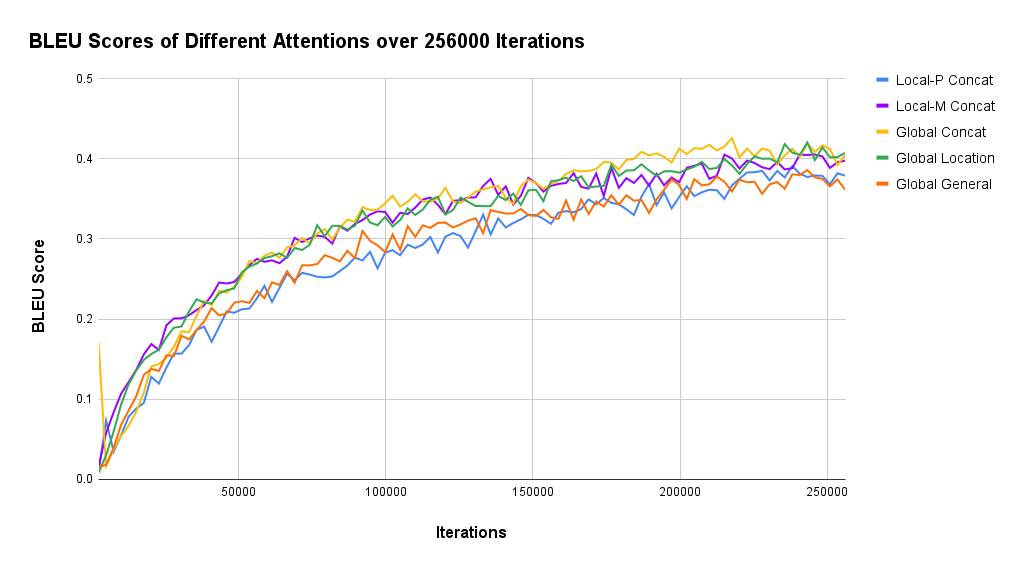

We analyse the general trends of the BLEU scores, and see that the global concat model has the best performance. It reaches the highest BLEU score, while also converging sooner than the other models. However, many of the models (local-m concat, global concat, and global location) seem to have ended around the same BLEU score range, and generally fell within the same range throughout the iterations (only noticibly diverging around the 200,000th iteration). Because of this, we can also consider runtime, we can see that global location had the shortest runtime, followed by local-p concat.

Therefore, given the BLEU scores and the runtime from these experiments, we are inclined to conclude that global location is the best attention model to optimize both runtime and BLEU scores. 

Lastly, the BLEU scores for each of the attention model tests are as follows: (with 505 translated sentences)


*   local-p concat: 0.364967679986629

*   local-m concat: 0.39171347587159666

*   global concat: 0.413031735715621

*   global location: 0.405317565074815

*   global general: 0.3835585753

Our conclusions are further verified by the fact that the global concat and global location had the highest yet very similar BLEU scores, indicating that global location is still a good choice if we want to optimize runtime. 





In [ ]:
df = pd.DataFrame({'attention': attention, 'run time': run_time, 'scores': scores})

ax = df.plot(kind="bar", x='attention', y='scores', legend=False)
ax.set_xlabel("Attention Type")
ax.set_ylabel("BLEU scores")

## Window Size


---

We also ran experiments with different window sizes (D = 4 and D = 6, hard-coded in the AlignmentRNN class in the different files). For all of the experiments above, we used an empirically determined window size (from the paper), where D = 2. Therefore, we wanted to experiment with different sizes. The default parameters for attention changed to alignment = "local-m" and score = "concat," since window size does not apply to global attention, and the combination of alignment = "local-m" and score= "concat" had the best BLEU scores. In the bar graphs below (one for runtime, and the other for test data BLEU scores ), the D = 2 data was taken from the attention experiments (i.e. local-m concat). 

The training model for window size D = 6 exited prematurely, but from the data that we have about the BLEU scores, we can see that the trend shows that D = 2 performs slightly better than D = 4, which performs slightly better than D = 6. We also notice that D = 2 has the fastest runtime, followed closely by D = 4, and then D = 6. Therefore, from both BLEU score and runtime trends, a window size of D = 2 is best.

Most likely, more experiments would need to be run (especially a full run with D = 6), with different combinations of window sizes and attention types, to ensure that the correct window size and attention type is attained.

In [ ]:
import pandas as pd

window = ['D = 2','D = 4', 'D = 6']
run_time = [2876.070097, 2894.188324, 3512.395383]
scores = [0.413031735715621, 0.3831480750392715, 0]

df = pd.DataFrame({'window size': window, 'run time': run_time, 'scores': scores})

ax = df.plot(kind="bar", x='window size', y='run time', legend=False, ylim = [2500, 3000])
ax.set_xlabel("Window Size")
ax.set_ylabel("Runtime")

In [ ]:
df = pd.DataFrame({'window size': window, 'run time': run_time, 'scores': scores})

ax = df.plot(kind="bar", x='window size', y='scores', legend=False, ylim = [0.3, 0.42])
ax.set_xlabel("Window Size")
ax.set_ylabel("BLEU Scores")

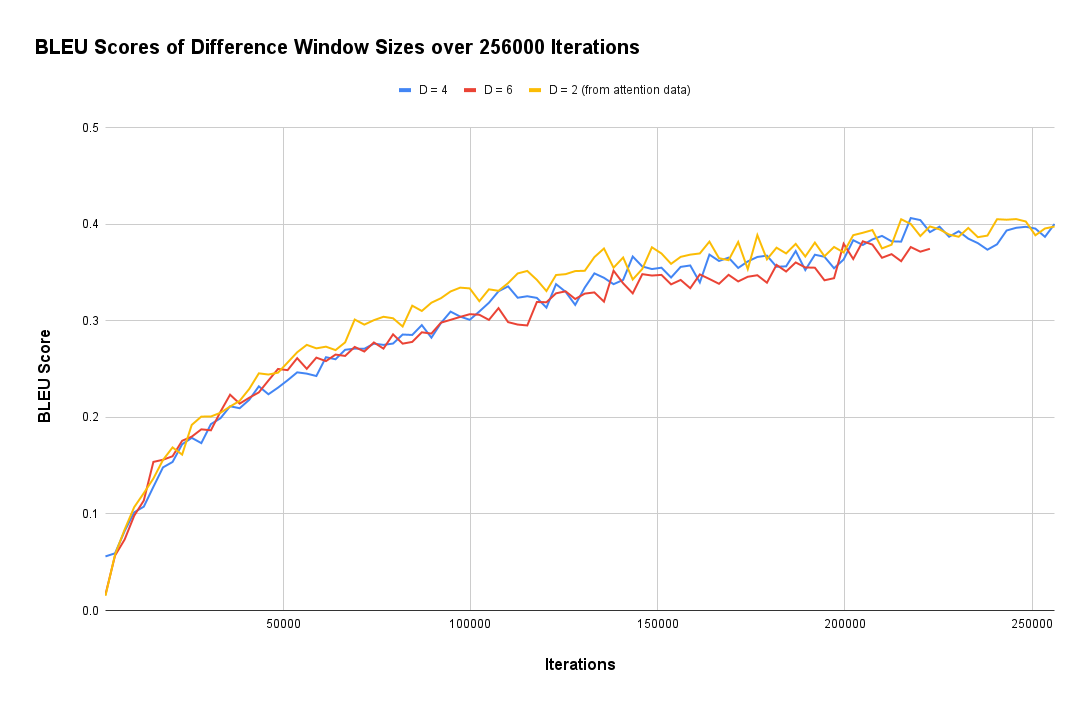

Looking at the trend of the BLEU scores of the various window sizes, D = 2 is slightly better than D = 4, which is slightly better than D = 6.

## Links to Colab Notebooks

---
Below are the colab notebooks that we used to run simultaneous experiments. Each notebook is not complete, and rather was only used to run the specific experiment indicated. 

batch=128: https://colab.research.google.com/drive/1gv2loQdM6q4ErxR-mnmwu7ZCkTiMfSRJ?usp=sharing

batch=64: https://colab.research.google.com/drive/1krrm74YMo3dVEQUM0NLtNK9p_OTACXD1?usp=sharing

batch=32: https://colab.research.google.com/drive/1wyHOikUdWozIsqH4TfchII0iKwgV1la9?usp=sharing

batch=16: https://colab.research.google.com/drive/1kE8-Q6peCob3Bfl9ySpQJukXM1VDQ817?usp=sharing

batch=8: https://colab.research.google.com/drive/1SllX7uiq0uTY7cjofrglXi8_niO2TGMA?usp=sharing

batch=4: https://colab.research.google.com/drive/1kf0BD4WXnRndlIngelGZXHhCxjn28Cdw?usp=sharing

batch=2: https://colab.research.google.com/drive/1jvf2lxuvJjgW2NoC3zn2YdPVJk_uZ9sq?usp=sharing

batch=1: https://colab.research.google.com/drive/1SDAidjtHRywoh5VaeJ5yLeGQwAoXHAzA?usp=sharing

reverse no-tf batch=8: https://colab.research.google.com/drive/1euuKAhd_f_J2b787B56RQKnqryQgzg6_?usp=sharing

no-tf no-reverse batch=8: https://colab.research.google.com/drive/1Xsgs1G9sw6akGAaLgMm8Zd5NRx-t3yw7?usp=sharing

reverse no-tf batch=16: https://colab.research.google.com/drive/1z6O6-XCgIgtEo5LtcW4Z7Jl3p0Ek_Uod?usp=sharing

no-tf no-reverse batch=16: https://colab.research.google.com/drive/1PZ6Zc8JPgi4rFuPDQfjYM3afS0gmCPpF?usp=sharing

global location: https://colab.research.google.com/drive/1Q8oLzzaofNl2YQG1qf3NzmO6E4jaQOAV?usp=sharing

global general: https://colab.research.google.com/drive/1bOJOyKP0aUOBc3ALTeDjJyMFy3B0iW4-?usp=sharing

global concat: https://colab.research.google.com/drive/1zqqamEyh-IDJAxjlJhWXIPkKE2dwcOqP?usp=sharing

local-p concat: https://colab.research.google.com/drive/1hWR9qUVeEt62HE4HA06EcQ7k6btOmP3l?usp=sharing

local-m concat: https://colab.research.google.com/drive/1KGXgNefr9bcvZcGNJ6lXZr0f2H-j5Fpx?usp=sharing

D = 4: https://colab.research.google.com/drive/1BDxWV8PiVm0gd9JiWzR9eGj4umo76KLa?usp=sharing

D = 6: https://colab.research.google.com/drive/1HAE0WDHlmL2wF1bIQs-eKhJxiQ1aSjMR?usp=sharing


